### Dataset consists of 4 keys ->

1.) X_jets (Images with 3 channels, and size 125 * 125) <br>
2.) m0 (Mass) <br>
3.) pt (Transverse momentum) <br>
4.) y (Labels) <br>

In state-of-the-art Jet Image Taggers, 4-tuple

For this screening task, as asked I am constructing an Autoencoder (Variational) to act upon Jet Images

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import h5py
import numpy as np
filename = '/content/drive/MyDrive/quark-gluon_data-set_n139306.hdf5'

def load_h5(file_name, size):
    # Load the dataset from the HDF5 file
    with h5py.File(file_name, 'r') as f:
        print("The keys are : ", list(f.keys()))
        print("The number of images in dataset : ", len(f['X_jets']))
        print("Dimensions of image tensor : ", f['X_jets'].shape[1:])
        X = np.array(f['X_jets'][:size])
        y = np.array(f['y'][:size])
    return X, y

In [3]:
X, y = load_h5(filename, 10000)

The keys are :  ['X_jets', 'm0', 'pt', 'y']
The number of images in dataset :  139306
Dimensions of image tensor :  (125, 125, 3)


In [4]:
def data_info_getter(X, y):

    print("Max value of intensity along 1st channel : ", np.max(X[:,:,:,0]), "   Min value : ", np.min(X[:,:,:,0]))
    print("Mean intensity value along 1st channel : ", np.mean(X[:,:,:,0]))
    print("Standard Deviation : ", np.std(X[:,:,:,0]), "\n\n")

    print("Max value of intensity along 2nd channel : ", np.max(X[:,:,:,1]), "   Min value : ", np.min(X[:,:,:,1]))
    print("Mean intensity value along 2nd channel : ", np.mean(X[:,:,:,1]))
    print("Standard Deviation : ", np.std(X[:,:,:,1]), "\n\n")


    print("Max value of intensity along 3rd channel : ", np.max(X[:,:,2]), "   Min value : ", np.min(X[:,:,:,2]))
    print("Mean intensity value along 3rd channel : ", np.mean(X[:,:,:,2]))
    print("Standard Deviation : ", np.std(X[:,:,:,2]), "\n\n")

    combined_dataset = X[:,:,:,0] + X[:,:,:,1] + X[:,:,:,2]
    combined_dataset = np.expand_dims(combined_dataset, axis= 3)

    print("Max value of intensity in combined channel image : ", np.max(combined_dataset[:,:,:,0]), "   Min value : ", np.min(combined_dataset[:,:,:,0]))
    print("Mean intensity value in combined channel : ", np.mean(combined_dataset[:,:,:,0]))
    print("Standard Deviation : ", np.std(combined_dataset[:,:,:,0]), "\n\n")
    return

In [5]:
data_info_getter(X,y)

Max value of intensity along 1st channel :  10.088105    Min value :  0.0
Mean intensity value along 1st channel :  7.8410376e-05
Standard Deviation :  0.0038757673 


Max value of intensity along 2nd channel :  9.334086    Min value :  0.0
Mean intensity value along 2nd channel :  4.9682043e-05
Standard Deviation :  0.0021076745 


Max value of intensity along 3rd channel :  0.24324848    Min value :  0.0
Mean intensity value along 3rd channel :  3.119493e-05
Standard Deviation :  0.00051332446 


Max value of intensity in combined channel image :  12.1562605    Min value :  0.0
Mean intensity value in combined channel :  0.0001592877
Standard Deviation :  0.004635658 




In [6]:
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt


#Plotting functions for the images -->

def plot_fxn(X):

    print("For the first image in the passed data batch -> \n")


    X_sample = X[0]
    print("For the first image among the batch passed : ")
    print("Max value of intensity along 1st channel : ", np.max(X_sample[:,:,0]), "   Min value : ", np.min(X_sample[:,:,0]))
    print("Max value of intensity along 2nd channel : ", np.max(X_sample[:,:,1]), "   Min value : ", np.min(X_sample[:,:,1]))
    print("Max value of intensity along 3rd channel : ", np.max(X_sample[:,:,2]), "   Min value : ", np.min(X_sample[:,:,2]))
    og_plot = plt.imshow(X_sample)


    fig, axs = plt.subplots(1, 3, figsize=(20, 20))

    im1 = axs[0].imshow(X_sample[:,:,0], cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
    axs[0].set_title('Track')

    im2 = axs[1].imshow(X_sample[:, :, 1], cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
    axs[1].set_title('ECAL')

    im3 = axs[2].imshow(X_sample[:, :,2], cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
    axs[2].set_title('HCAL')

    # Add colorbars
    fig.colorbar(im1, ax=axs[0], shrink=0.25)
    fig.colorbar(im2, ax=axs[1], shrink=0.25)
    fig.colorbar(im3, ax=axs[2], shrink=0.25)

    plt.show()

    return None

Plotting the given dataset, we realize that the intensity values (calorimeter hits) across all the channels (Track, ECAL, HCAL) vary highly, and that there is a need to perform data pre-processing - Namely, Normalization of intensity values and Standardization of the intensity distribution.

For the first image in the passed data batch -> 

For the first image among the batch passed : 
Max value of intensity along 1st channel :  0.24925861    Min value :  0.0
Max value of intensity along 2nd channel :  0.1778053    Min value :  0.0
Max value of intensity along 3rd channel :  0.0037489757    Min value :  0.0


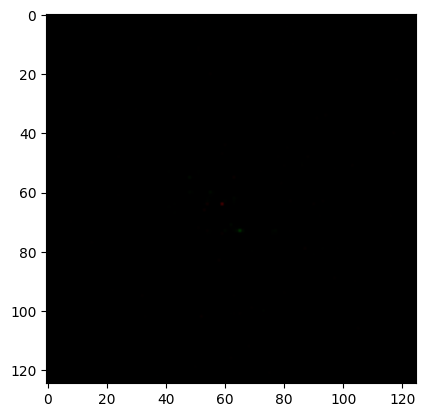

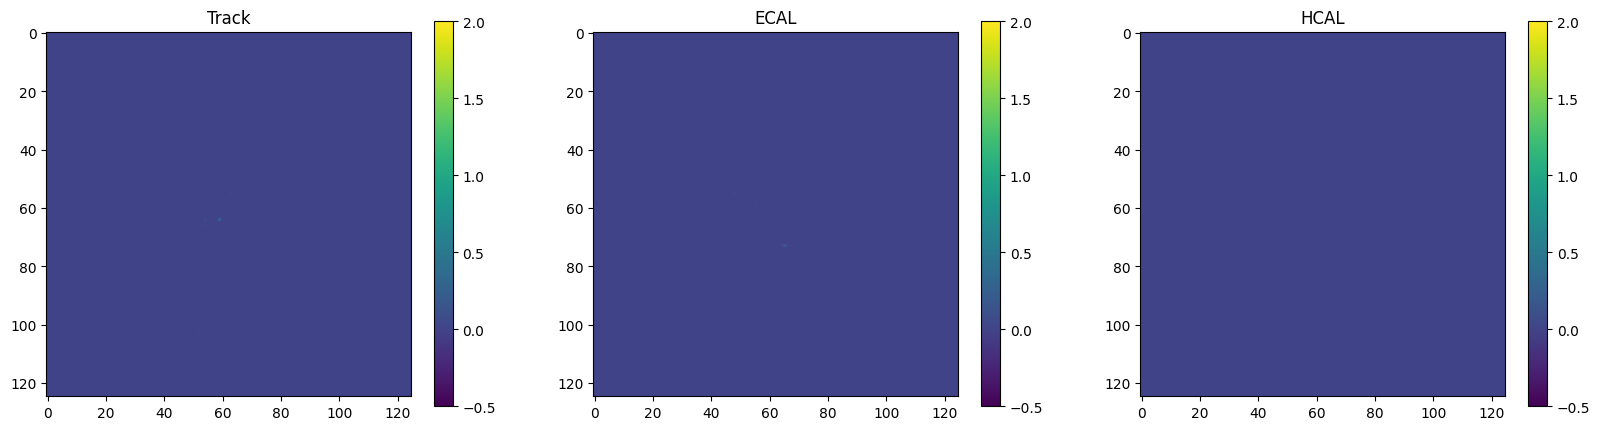

In [7]:
plot_fxn(X)

* The idea behind jet images is to treat the energy deposits in a calorimeter as intensities in a 2D image.
* A jet image is formed by taking the constituents of a jet and discretizing its energy into pixels in (η,φ), with the intensity of each pixel given by the sum of the energy of all constituents of the jet inside that (η,φ) pixel.

* The precise procedure followed for pre-processing of jet images involves rotations, re-pixelizations etc. I am building this Autoencoder while treating these jet images as a normal instance of classical images, hence I simply used the standard normalization and standardization processes as are used on images.

* I assumed that the intricacies of data handling (being more theoretically motivated) are BEYOND THE SCOPE OF THIS EVALUATION TASK.

In [8]:
from skimage.transform import resize
from sklearn.preprocessing import normalize

def data_preprocess(X_jets):
    #Normalizing the images

    # Resizing images from (125, 125, 3) to (128, 128, 3)
    resized_images = np.zeros((X_jets.shape[0], 128, 128, 3), dtype=np.float32)
    for i in range(X_jets.shape[0]):
        resized_images[i] = resize(X_jets[i], (128, 128), anti_aliasing=True)

    X_jets = resized_images
    del resized_images

    # Standardizing the distribution across all channels
    mean = np.mean(X_jets)
    std = np.std(X_jets)
    X_jets = (X_jets - mean) / std

    # Clipping negative intensity values to 0...
    X_jets = np.clip(X_jets, 0, None)
    return X_jets


### Image Resizing

The function `data_preprocess()` begins by resizing the input images. This resizing step is essential for standardizing the dimensions of all images in the dataset. In this case, the original images are of size (125, 125, 3), where 125x125 represents the width and height of the image, and 3 represents the number of channels (RGB). However, VAEs typically work with fixed-size inputs. Therefore, the images are resized to a common size of (128, 128, 3) using bilinear interpolation. This resizing ensures that all images have consistent dimensions, which is crucial for feeding them into the neural network model later.

### Standardization

After resizing, the function performs standardization on the images. Standardization involves transforming the data such that it has a mean of 0 and a standard deviation of 1 across each channel. This step helps in stabilizing the learning process by making the input data more amenable to optimization algorithms. By ensuring that the distribution of pixel intensities across different images is consistent, standardization can improve the convergence and performance of the VAE during training.

### Clipping Negative Intensity Values

Finally, the function clips any negative intensity values in the images to zero. This step is commonly performed in image processing tasks to ensure that all pixel values are within a valid range. Since negative pixel intensities do not make sense in the context of most image data, clipping them to zero helps in removing noise or inconsistencies in the dataset.


In [9]:
X_jets = data_preprocess(X)

In [10]:
data_info_getter(X_jets, y)

Max value of intensity along 1st channel :  2362.628    Min value :  0.0
Mean intensity value along 1st channel :  0.04981079
Standard Deviation :  1.4279369 


Max value of intensity along 2nd channel :  2024.9122    Min value :  0.0
Mean intensity value along 2nd channel :  0.03096904
Standard Deviation :  0.92825264 


Max value of intensity along 3rd channel :  97.2833    Min value :  0.0
Mean intensity value along 3rd channel :  0.018975094
Standard Deviation :  0.30354062 


Max value of intensity in combined channel image :  3176.8347    Min value :  0.0
Mean intensity value in combined channel :  0.099754974
Standard Deviation :  1.9071484 




Note, in the following plot, we are yet to normalize each image channel-wise.

For the first image in the passed data batch -> 

For the first image among the batch passed : 
Max value of intensity along 1st channel :  52.13446    Min value :  0.0
Max value of intensity along 2nd channel :  59.500538    Min value :  0.0
Max value of intensity along 3rd channel :  2.3792415    Min value :  0.0


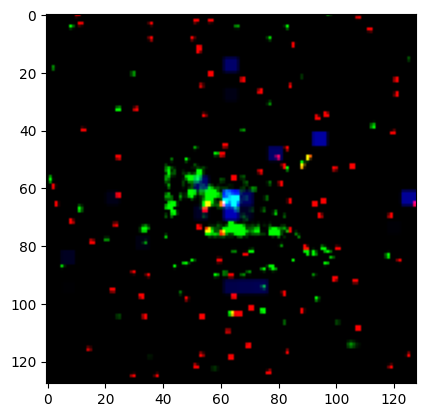

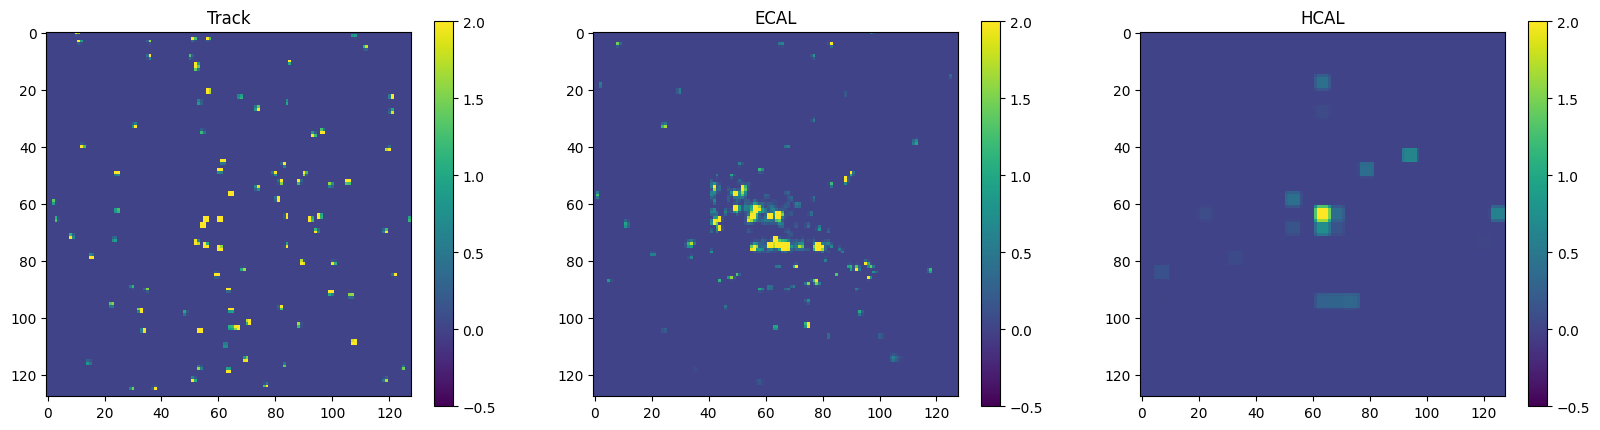

In [11]:
plot_fxn(X_jets)

Relevant data classes are `X_jets` and `y` ->

Loading these datasets using standard PyTorch dataloader ->

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [13]:
from torch.distributions import Normal


class Sampling(nn.Module):
    def forward(self, z_mean, z_log_var):
        # Get the shape of the tensor for the mean and log variance.
        batch, dim = z_mean.shape
        # Generate a normal random tensor (epsilon) with the same shape as z_mean
        # This tensor will be used for reparameterization trick
        epsilon = Normal(0, 1).sample((batch, dim)).to(z_mean.device)
        # Apply the reparameterization trick to generate the samples in the
        # latent space
        return z_mean + torch.exp(0.5 * z_log_var) * epsilon

In [14]:

# Define the Encoder
class Encoder(nn.Module):
    def __init__(self, embedding_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.sampling = Sampling()
        # Calculate the size of the flattened tensor
        # Assuming the image size is 128x128
        # After the first conv layer: 64x64
        # After the second conv layer: 32x32
        # After the third conv layer: 16x16
        # After the fourth conv layer: 8x8
        # Flattened size: 8*8*512 = 32768
        self.fc_mu = nn.Linear(32768, embedding_dim)
        self.fc_logvar = nn.Linear(32768, embedding_dim)

    def forward(self, x):

#        print(x.shape)
        # Assuming `x` is the input tensor with dimensions (N, H, W, C)
#        x = x.permute(0, 3, 1, 2) # Permute to (N, C, H, W)

        # Apply the convolutional layers with batch normalization
        x = self.bn1(self.conv1(x))
        x = nn.LeakyReLU(0.2)(x)
        x = self.bn2(self.conv2(x))
        x = nn.LeakyReLU(0.2)(x)
        x = self.bn3(self.conv3(x))
        x = nn.LeakyReLU(0.2)(x)
        x = self.bn4(self.conv4(x))
        x = nn.LeakyReLU(0.2)(x)

        # With this line
        x = x.reshape(x.size(0), -1)

        # Apply the fully connected layers to get the mean and log variance
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        # Sample a latent vector using reparameterization trick
        z = self.sampling(mu, logvar)

        return mu, logvar, z


# class Encoder(nn.Module):
#     def __init__(self, latent_dim, img_size):
#         super(Encoder, self).__init__()
#
#         self.latent_dim = latent_dim
#         self.img_size = img_size
#         self.channels = 3
#
#         self.conv1 =  nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
#     #    self.conv4 = nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1)
#         self.flatten = nn.Flatten()
#
#         # Parameters for the latent space
#         self.fc_mean = nn.Linear(128 * (img_size//8) * (img_size//8), latent_dim)
#         self.fc_log_var = nn.Linear(128 * (img_size//8) * (img_size//8), latent_dim)
#
#         # Initializing the sampling layer as well,
#         self.sampling = Sampling()
#

In [15]:
# Decoder
import torch.nn.functional as F

import torch
import torch.nn as nn

class Decoder(nn.Module):
    def __init__(self, embedding_dim):
        super(Decoder, self).__init__()

        # Fully connected layer to map the latent vector back to the size of the flattened tensor
        self.fc = nn.Linear(embedding_dim, 32768)

        # Transposed convolutional layers to upscale the tensor
        self.deconv1 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn1 = nn.BatchNorm2d(256)
        self.deconv2 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.deconv3 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.deconv4 = nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1)

        # Final activation function
        self.tanh = nn.Tanh()

    def forward(self, z):
        # Fully connected layer
        x = self.fc(z)
        x = x.view(z.size(0), 512, 8, 8)

        # Transposed convolutional layers
        x = self.bn1(self.deconv1(x))
        x = nn.LeakyReLU(0.2)(x)
        x = self.bn2(self.deconv2(x))
        x = nn.LeakyReLU(0.2)(x)
        x = self.bn3(self.deconv3(x))
        x = nn.LeakyReLU(0.2)(x)
        x = self.deconv4(x)

        # Final activation
        x = (self.tanh(x) + 1)/2.

        return x

#     def forward(self, x):
#         # Pass the latent vector through the fully connected layer
#         x = self.fc(x)
#         # Reshape the tensor
#         x = self.reshape(x)
#         # Apply transposed convolutional layers with relu activation function
# #        x = F.relu(self.deconv1(x))
#         x = F.relu(self.deconv2(x))
#         x = F.relu(self.deconv3(x))
#         # Apply the final transposed convolutional layer with a sigmoid
#         # activation to generate the final output
#         x = 0.5 * (torch.sigmoid(self.deconv4(x)) + 1)
#
#
#         return x

In [16]:
#!pip install pytorch-lightning

In [17]:

#import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, embedding_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(embedding_dim)
        self.decoder = Decoder(embedding_dim)

    def forward(self, x):
        mu, logvar, z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mu, logvar

    def vae_gaussian_kl_loss(self, mu, logvar):
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
        return KLD.mean()

    def reconstruction_loss(self, x_reconstructed, x):
        bce_loss = nn.BCELoss()
        return bce_loss(x_reconstructed, x)

    def vae_loss(self, x_reconstructed, x, mu, logvar):
        recon_loss = self.reconstruction_loss(x_reconstructed, x)
        kld_loss = self.vae_gaussian_kl_loss(mu, logvar)
        return 500 * recon_loss + kld_loss


In [18]:
# # Define loss function
# #KL Divergence is computed between the learned latent variable distribution and a standard normal distribution.
# def vae_gaussian_kl_loss(mu, logvar):
#     # see Appendix B from VAE paper:
#     # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
#     # https://arxiv.org/abs/1312.6114
#     KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
#     return KLD.mean()
#
# def reconstruction_loss(x_reconstructed, x):
#     bce_loss = nn.BCELoss()
#     return bce_loss(x_reconstructed, x)
#
#
# def vae_loss(y_pred, y_true):
#     mu, logvar, recon_x = y_pred
#     recon_loss = reconstruction_loss(recon_x, y_true)
#     kld_loss = vae_gaussian_kl_loss(mu, logvar)
#     return 500 * recon_loss + kld_loss
# # def vae_loss(reconstructed, original, mu, log_var):
# #     reconstruction_loss = F.binary_cross_entropy(reconstructed, original, reduction='sum')
# #     kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
# #     return reconstruction_loss + kl_divergence

In [19]:
trackMax = np.max(X_jets[:,:,:,0])
ecalMax = np.max(X_jets[:,:,:,1])
hcalMax = np.max(X_jets[:,:,:,2])


X_jets[:,:,:,0] = X_jets[:,:,:,0]/trackMax
X_jets[:,:,:,1] = X_jets[:,:,:,1]/ecalMax
X_jets[:,:,:,2] = X_jets[:,:,:,2]/hcalMax

In [20]:
data_info_getter(X_jets, y)

Max value of intensity along 1st channel :  1.0    Min value :  0.0
Mean intensity value along 1st channel :  2.1082873e-05
Standard Deviation :  0.00060438446 


Max value of intensity along 2nd channel :  1.0    Min value :  0.0
Mean intensity value along 2nd channel :  1.5294063e-05
Standard Deviation :  0.00045841653 


Max value of intensity along 3rd channel :  0.041175887    Min value :  0.0
Mean intensity value along 3rd channel :  8.1936e-05
Standard Deviation :  0.0013107107 


Max value of intensity in combined channel image :  1.6550479    Min value :  0.0
Mean intensity value in combined channel :  0.00011831272
Standard Deviation :  0.0016820171 




In [21]:
from sklearn.model_selection import train_test_split

# Assuming X_jets is your dataset and y are the labels
X_jets_train, X_jets_test, y_train, y_test = train_test_split(X_jets, y, test_size=0.3, random_state=42)
X_jets_train, X_jets_val, y_train, y_val = train_test_split(X_jets_train, y_train, test_size=0.25, random_state=42)

In [22]:
import torch
from torch.utils.data import Dataset

class JetDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __getitem__(self, index):
        # X is in the format (h, w, channels)
        # Permute the dimensions to (channels, h, w)
        image = self.X[index].permute(2, 0, 1)
        return image, self.y[index]

    def __len__(self):
        return len(self.X)

# Convert your data to PyTorch tensors
train_dataset = JetDataset(torch.from_numpy(X_jets_train), torch.from_numpy(y_train))
val_dataset = JetDataset(torch.from_numpy(X_jets_val), torch.from_numpy(y_val))
test_dataset = JetDataset(torch.from_numpy(X_jets_test), torch.from_numpy(y_test))

In [23]:
from tqdm import tqdm

In [24]:
torch.cuda.is_available()

True

In [25]:
from torch.utils.data import DataLoader
import torch.optim as optim


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(embedding_dim= 2048).to(device) # Adjust embedding_dim as needed
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = model.vae_loss

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# Training loop
num_epochs = 100
train_losses = []
val_losses = []

# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0
#     for batch_idx, (data, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}")):
#         optimizer.zero_grad()
#         recon_batch, mu, logvar = model(data)
#         loss = criterion(recon_batch, data, mu, logvar)
#         loss.backward()
#         train_loss += loss.item()
#         optimizer.step()
#     train_losses.append(train_loss / len(train_loader))

#     model.eval()
#     val_loss = 0
#     with torch.no_grad():
#         for batch_idx, (data, _) in enumerate(val_loader):
#             recon_batch, mu, logvar = model(data)
#             loss = criterion(recon_batch, data, mu, logvar)
#             val_loss += loss.item()
#     val_losses.append(val_loss / len(val_loader))
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}")):
        data = data.to(device) # Move data to device
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = criterion(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    train_losses.append(train_loss / len(train_loader))

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(val_loader):
            data = data.to(device) # Move data to device
            recon_batch, mu, logvar = model(data)
            loss = criterion(recon_batch, data, mu, logvar)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))

    print(f'Epoch: {epoch+1}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}')

Epoch 0: 100%|██████████| 42/42 [00:13<00:00,  3.09it/s]


Epoch: 1, Train Loss: 1517.307880219959, Val Loss: 706.8497576032366


Epoch 1: 100%|██████████| 42/42 [00:11<00:00,  3.61it/s]


Epoch: 2, Train Loss: 100368.12159801665, Val Loss: 629.3060259137835


Epoch 2: 100%|██████████| 42/42 [00:11<00:00,  3.60it/s]


Epoch: 3, Train Loss: 1310.230221702939, Val Loss: 539.3781651088169


Epoch 3: 100%|██████████| 42/42 [00:11<00:00,  3.59it/s]


Epoch: 4, Train Loss: 2196405.9934874037, Val Loss: 1243.2036917550224


Epoch 4: 100%|██████████| 42/42 [00:11<00:00,  3.56it/s]


Epoch: 5, Train Loss: 480.47375342959447, Val Loss: 641.8767569405692


Epoch 5: 100%|██████████| 42/42 [00:12<00:00,  3.49it/s]


Epoch: 6, Train Loss: 401.89897591727123, Val Loss: 381.74291556222096


Epoch 6: 100%|██████████| 42/42 [00:11<00:00,  3.51it/s]


Epoch: 7, Train Loss: 354.28039986746654, Val Loss: 329.06580897739957


Epoch 7: 100%|██████████| 42/42 [00:12<00:00,  3.47it/s]


Epoch: 8, Train Loss: 317.18683951241627, Val Loss: 296.14515904017856


Epoch 8: 100%|██████████| 42/42 [00:12<00:00,  3.35it/s]


Epoch: 9, Train Loss: 285.77979460216704, Val Loss: 267.812986101423


Epoch 9: 100%|██████████| 42/42 [00:12<00:00,  3.38it/s]


Epoch: 10, Train Loss: 258.50159635997954, Val Loss: 242.91566794259208


Epoch 10: 100%|██████████| 42/42 [00:12<00:00,  3.35it/s]


Epoch: 11, Train Loss: 234.66242072695778, Val Loss: 220.61823381696428


Epoch 11: 100%|██████████| 42/42 [00:12<00:00,  3.39it/s]


Epoch: 12, Train Loss: 213.73625946044922, Val Loss: 201.5021198817662


Epoch 12: 100%|██████████| 42/42 [00:12<00:00,  3.41it/s]


Epoch: 13, Train Loss: 195.18009549095518, Val Loss: 184.05130767822266


Epoch 13: 100%|██████████| 42/42 [00:12<00:00,  3.42it/s]


Epoch: 14, Train Loss: 178.73256174723306, Val Loss: 169.10850742885046


Epoch 14: 100%|██████████| 42/42 [00:12<00:00,  3.41it/s]


Epoch: 15, Train Loss: 164.1757787068685, Val Loss: 155.31002044677734


Epoch 15: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]


Epoch: 16, Train Loss: 151.2581031436012, Val Loss: 143.69250270298548


Epoch 16: 100%|██████████| 42/42 [00:12<00:00,  3.37it/s]


Epoch: 17, Train Loss: 139.90029126121885, Val Loss: 132.94635336739677


Epoch 17: 100%|██████████| 42/42 [00:12<00:00,  3.35it/s]


Epoch: 18, Train Loss: 129.77661968412855, Val Loss: 123.64188929966518


Epoch 18: 100%|██████████| 42/42 [00:12<00:00,  3.38it/s]


Epoch: 19, Train Loss: 120.95669937133789, Val Loss: 115.40678296770368


Epoch 19: 100%|██████████| 42/42 [00:12<00:00,  3.39it/s]


Epoch: 20, Train Loss: 113.12313552129837, Val Loss: 108.27248055594308


Epoch 20: 100%|██████████| 42/42 [00:12<00:00,  3.39it/s]


Epoch: 21, Train Loss: 106.34064556303478, Val Loss: 102.16236822945731


Epoch 21: 100%|██████████| 42/42 [00:12<00:00,  3.33it/s]


Epoch: 22, Train Loss: 100.39103135608491, Val Loss: 96.85812813895089


Epoch 22: 100%|██████████| 42/42 [00:12<00:00,  3.38it/s]


Epoch: 23, Train Loss: 95.3472649710519, Val Loss: 92.24630083356585


Epoch 23: 100%|██████████| 42/42 [00:12<00:00,  3.38it/s]


Epoch: 24, Train Loss: 90.93552344185966, Val Loss: 88.48523221697126


Epoch 24: 100%|██████████| 42/42 [00:12<00:00,  3.38it/s]


Epoch: 25, Train Loss: 87.1621813092913, Val Loss: 85.07380512782505


Epoch 25: 100%|██████████| 42/42 [00:12<00:00,  3.38it/s]


Epoch: 26, Train Loss: 83.69492721557617, Val Loss: 81.8027697971889


Epoch 26: 100%|██████████| 42/42 [00:12<00:00,  3.38it/s]


Epoch: 27, Train Loss: 80.57647913978214, Val Loss: 79.01174926757812


Epoch 27: 100%|██████████| 42/42 [00:12<00:00,  3.37it/s]


Epoch: 28, Train Loss: 77.58835002354213, Val Loss: 76.24156134469169


Epoch 28: 100%|██████████| 42/42 [00:12<00:00,  3.38it/s]


Epoch: 29, Train Loss: 74.94690740676154, Val Loss: 73.93984821864537


Epoch 29: 100%|██████████| 42/42 [00:12<00:00,  3.33it/s]


Epoch: 30, Train Loss: 72.31482796441941, Val Loss: 71.30298233032227


Epoch 30: 100%|██████████| 42/42 [00:12<00:00,  3.37it/s]


Epoch: 31, Train Loss: 69.92762765430268, Val Loss: 69.0817505972726


Epoch 31: 100%|██████████| 42/42 [00:12<00:00,  3.37it/s]


Epoch: 32, Train Loss: 67.5577593303862, Val Loss: 66.59993198939732


Epoch 32: 100%|██████████| 42/42 [00:12<00:00,  3.39it/s]


Epoch: 33, Train Loss: 65.40548333667573, Val Loss: 64.55597387041364


Epoch 33: 100%|██████████| 42/42 [00:12<00:00,  3.37it/s]


Epoch: 34, Train Loss: 63.25942121233259, Val Loss: 62.29562268938337


Epoch 34: 100%|██████████| 42/42 [00:12<00:00,  3.38it/s]


Epoch: 35, Train Loss: 61.33881995791481, Val Loss: 60.518113817487446


Epoch 35: 100%|██████████| 42/42 [00:12<00:00,  3.38it/s]


Epoch: 36, Train Loss: 59.64799054463705, Val Loss: 58.71319716317313


Epoch 36: 100%|██████████| 42/42 [00:12<00:00,  3.38it/s]


Epoch: 37, Train Loss: 58.20131356375558, Val Loss: 57.283232825142996


Epoch 37: 100%|██████████| 42/42 [00:12<00:00,  3.36it/s]


Epoch: 38, Train Loss: 56.866356259300595, Val Loss: 55.717127663748606


Epoch 38: 100%|██████████| 42/42 [00:12<00:00,  3.33it/s]


Epoch: 39, Train Loss: 55.75938488188244, Val Loss: 54.61871828351702


Epoch 39: 100%|██████████| 42/42 [00:12<00:00,  3.38it/s]


Epoch: 40, Train Loss: 54.87851787748791, Val Loss: 53.4486266544887


Epoch 40: 100%|██████████| 42/42 [00:12<00:00,  3.38it/s]


Epoch: 41, Train Loss: 54.165476571945916, Val Loss: 52.66240555899484


Epoch 41: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]


Epoch: 42, Train Loss: 53.53860110328311, Val Loss: 51.64766992841448


Epoch 42: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]


Epoch: 43, Train Loss: 53.000464212326776, Val Loss: 50.94170406886509


Epoch 43: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]


Epoch: 44, Train Loss: 52.4491351445516, Val Loss: 50.06640842982701


Epoch 44: 100%|██████████| 42/42 [00:12<00:00,  3.41it/s]


Epoch: 45, Train Loss: 51.95688111441476, Val Loss: 49.38294274466379


Epoch 45: 100%|██████████| 42/42 [00:12<00:00,  3.36it/s]


Epoch: 46, Train Loss: 51.30560906728109, Val Loss: 48.297453199114116


Epoch 46: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]


Epoch: 47, Train Loss: 50.70265056973412, Val Loss: 47.58302879333496


Epoch 47: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]


Epoch: 48, Train Loss: 50.0234435853504, Val Loss: 46.59123148236956


Epoch 48: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]


Epoch: 49, Train Loss: 49.514742896670384, Val Loss: 46.035670961652485


Epoch 49: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]


Epoch: 50, Train Loss: 49.02637191045852, Val Loss: 45.20064353942871


Epoch 50: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]


Epoch: 51, Train Loss: 48.63177086058117, Val Loss: 44.80252047947475


Epoch 51: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]


Epoch: 52, Train Loss: 48.21982810610817, Val Loss: 44.06317274911063


Epoch 52: 100%|██████████| 42/42 [00:12<00:00,  3.39it/s]


Epoch: 53, Train Loss: 47.823155857267835, Val Loss: 43.67856516156878


Epoch 53: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]


Epoch: 54, Train Loss: 47.41941610972086, Val Loss: 42.97939273289272


Epoch 54: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]


Epoch: 55, Train Loss: 47.0854168392363, Val Loss: 42.716352462768555


Epoch 55: 100%|██████████| 42/42 [00:12<00:00,  3.39it/s]


Epoch: 56, Train Loss: 46.79294826870873, Val Loss: 42.0972535269601


Epoch 56: 100%|██████████| 42/42 [00:12<00:00,  3.39it/s]


Epoch: 57, Train Loss: 46.60230663844517, Val Loss: 42.00055122375488


Epoch 57: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]


Epoch: 58, Train Loss: 46.48890740530832, Val Loss: 41.58392606462751


Epoch 58: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]


Epoch: 59, Train Loss: 46.444614319574264, Val Loss: 41.56030055454799


Epoch 59: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]


Epoch: 60, Train Loss: 46.37400354657854, Val Loss: 41.1433162689209


Epoch 60: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]


Epoch: 61, Train Loss: 46.30478650047665, Val Loss: 41.13148471287319


Epoch 61: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]


Epoch: 62, Train Loss: 46.17478647686186, Val Loss: 40.685646057128906


Epoch 62: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]


Epoch: 63, Train Loss: 46.05018420446487, Val Loss: 40.61278779166086


Epoch 63: 100%|██████████| 42/42 [00:12<00:00,  3.41it/s]


Epoch: 64, Train Loss: 45.86623963855562, Val Loss: 40.14404487609863


Epoch 64: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]


Epoch: 65, Train Loss: 45.72857911246164, Val Loss: 40.07403782435826


Epoch 65: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]


Epoch: 66, Train Loss: 45.521802720569426, Val Loss: 39.6459835597447


Epoch 66: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]


Epoch: 67, Train Loss: 45.37341867174421, Val Loss: 39.597507749285015


Epoch 67: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]


Epoch: 68, Train Loss: 45.15584909348261, Val Loss: 39.156524658203125


Epoch 68: 100%|██████████| 42/42 [00:12<00:00,  3.41it/s]


Epoch: 69, Train Loss: 45.027699198041645, Val Loss: 39.17704854692732


Epoch 69: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]


Epoch: 70, Train Loss: 44.8278542019072, Val Loss: 38.80789130074637


Epoch 70: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]


Epoch: 71, Train Loss: 44.68575895400274, Val Loss: 38.84048271179199


Epoch 71: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]


Epoch: 72, Train Loss: 44.52975000653948, Val Loss: 38.54716873168945


Epoch 72: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]


Epoch: 73, Train Loss: 44.45624115353539, Val Loss: 38.72958428519113


Epoch 73: 100%|██████████| 42/42 [00:12<00:00,  3.41it/s]


Epoch: 74, Train Loss: 44.36881158465431, Val Loss: 38.55649484906878


Epoch 74: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]


Epoch: 75, Train Loss: 44.341980888730006, Val Loss: 38.785861424037385


Epoch 75: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]


Epoch: 76, Train Loss: 44.293405033293226, Val Loss: 38.655421665736604


Epoch 76: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]


Epoch: 77, Train Loss: 44.2997541200547, Val Loss: 38.998636790684294


Epoch 77: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]


Epoch: 78, Train Loss: 44.275770414443244, Val Loss: 38.93533842904227


Epoch 78: 100%|██████████| 42/42 [00:12<00:00,  3.41it/s]


Epoch: 79, Train Loss: 44.24848408926101, Val Loss: 39.20821462358747


Epoch 79: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]


Epoch: 80, Train Loss: 44.15489739463443, Val Loss: 39.10960851396833


Epoch 80: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]


Epoch: 81, Train Loss: 44.10194135847546, Val Loss: 39.39777701241629


Epoch 81: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]


Epoch: 82, Train Loss: 43.98123713902065, Val Loss: 39.26023020063128


Epoch 82: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]


Epoch: 83, Train Loss: 43.89693339665731, Val Loss: 39.51509066990444


Epoch 83: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]


Epoch: 84, Train Loss: 43.767943745567685, Val Loss: 39.447146551949636


Epoch 84: 100%|██████████| 42/42 [00:12<00:00,  3.41it/s]


Epoch: 85, Train Loss: 43.72352273123605, Val Loss: 39.772804260253906


Epoch 85: 100%|██████████| 42/42 [00:12<00:00,  3.41it/s]


Epoch: 86, Train Loss: 43.61655705315726, Val Loss: 39.739091873168945


Epoch 86: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]


Epoch: 87, Train Loss: 43.58311444237118, Val Loss: 40.06026703970773


Epoch 87: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]


Epoch: 88, Train Loss: 43.50875663757324, Val Loss: 40.12670081002371


Epoch 88: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]


Epoch: 89, Train Loss: 43.59750638689314, Val Loss: 40.55877958025251


Epoch 89: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]


Epoch: 90, Train Loss: 43.60929137184506, Val Loss: 40.70946775163923


Epoch 90: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]


Epoch: 91, Train Loss: 43.724848066057476, Val Loss: 41.162919180733816


Epoch 91: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]


Epoch: 92, Train Loss: 43.71451339267549, Val Loss: 41.27104132516043


Epoch 92: 100%|██████████| 42/42 [00:12<00:00,  3.39it/s]


Epoch: 93, Train Loss: 43.79437950679234, Val Loss: 41.70071165902274


Epoch 93: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]


Epoch: 94, Train Loss: 43.814363933744886, Val Loss: 41.86067117963518


Epoch 94: 100%|██████████| 42/42 [00:12<00:00,  3.39it/s]


Epoch: 95, Train Loss: 43.96921761830648, Val Loss: 42.31438991001674


Epoch 95: 100%|██████████| 42/42 [00:12<00:00,  3.39it/s]


Epoch: 96, Train Loss: 44.040378843035015, Val Loss: 42.45038958958217


Epoch 96: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]


Epoch: 97, Train Loss: 44.141354765210835, Val Loss: 42.8663455418178


Epoch 97: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]


Epoch: 98, Train Loss: 44.10775080181303, Val Loss: 42.87109293256487


Epoch 98: 100%|██████████| 42/42 [00:12<00:00,  3.41it/s]


Epoch: 99, Train Loss: 44.09625598362514, Val Loss: 43.1228335244315


Epoch 99: 100%|██████████| 42/42 [00:12<00:00,  3.40it/s]


Epoch: 100, Train Loss: 44.013646239326114, Val Loss: 43.06130000523159


For the first image in the passed data batch -> 

For the first image among the batch passed : 
Max value of intensity along 1st channel :  5.626907    Min value :  0.0
Max value of intensity along 2nd channel :  7.4929852    Min value :  0.0
Max value of intensity along 3rd channel :  2.6198044    Min value :  0.0


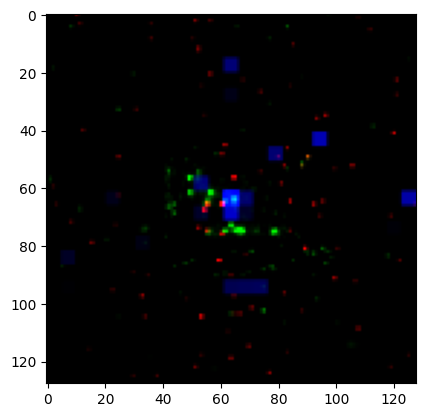

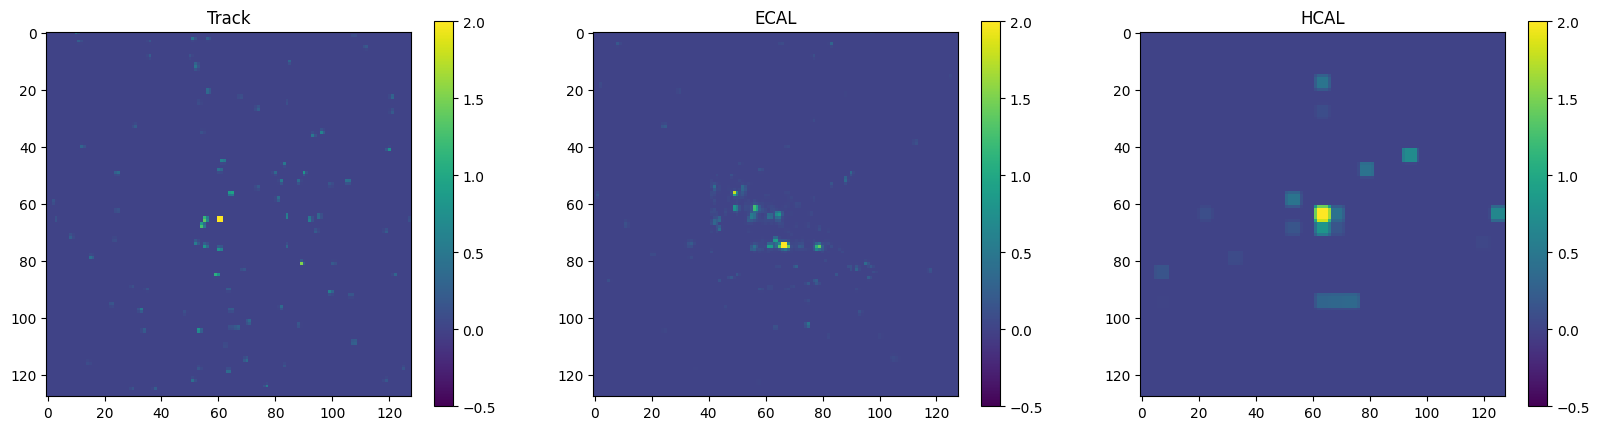

In [26]:
plot_fxn(X_jets*255.)

In [27]:
def reconstruct_image(original_image, model):
    # Ensure the image is a PyTorch tensor and on the correct device
    original_image = torch.from_numpy(original_image).float().to(device)
    # Reshape the image to match the input shape expected by the model
    original_image = original_image.unsqueeze(0) # Assuming the model expects a batch of images

    # Pass the image through the model to get the reconstructed image
    with torch.no_grad():
        reconstructed_image = model(original_image)

    # Convert the reconstructed image back to a NumPy array
    reconstructed_image = reconstructed_image[0]
    reconstructed_image = reconstructed_image.squeeze(0)
#    print(reconstructed_image.shape)
    reconstructed_image = reconstructed_image.cpu().numpy().astype(np.float32)

    reconstructed_image = np.transpose(reconstructed_image, (1, 2, 0))
#    print(reconstructed_image.shape)
    # # Reshape the reconstructed image to its original shape (128x128 for our case)
    # reconstructed_image = reconstructed_image.reshape(128, 128)

    return reconstructed_image

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# # Now that the model is trained, and we have already loaded a  DataLoader for the test data.
# test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# import matplotlib.pyplot as plt
# import numpy as np

# # Assuming the model is trained and you have a DataLoader for test data
# #test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# # Get a single image from the test dataset
# dataiter = iter(test_loader)
# images, _ = next(dataiter)
images = X_jets[0]
images[:,:,0] = (images[:,:,0] - np.min(images[:,:,0]))/(np.max(images[:,:,0]) - np.min(images[:,:,0]))
images[:,:,1] = (images[:,:,1] - np.min(images[:,:,1]))/(np.max(images[:,:,1]) - np.min(images[:,:,1]))
images[:,:,2] = (images[:,:,2] - np.min(images[:,:,2]))/(np.max(images[:,:,2]) - np.min(images[:,:,2]))
# Plot original image
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.imshow(images * 255.)
# plt.title('Original Image')
# plt.axis('off')

images = np.transpose(images, (2, 1, 0))
#images.to(device)
reconstructed_image = reconstruct_image(images, model)

#reconstructed_image = np.clip(reconstructed_image, 0, None)
# Scale the reconstructed image by 255.0 and convert to numpy
reconstructed_image_scaled = reconstructed_image


For the first image among the batch passed : 
Max value of intensity along 1st channel :  1.0    Min value :  0.0
Max value of intensity along 2nd channel :  1.0    Min value :  0.0
Max value of intensity along 3rd channel :  1.0    Min value :  0.0


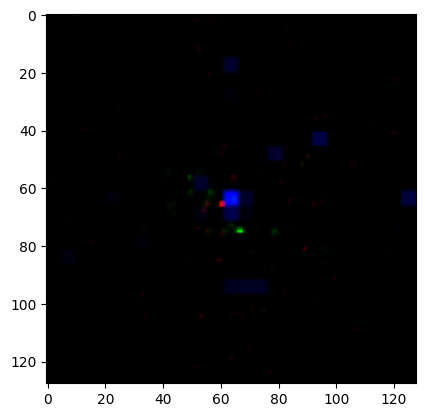

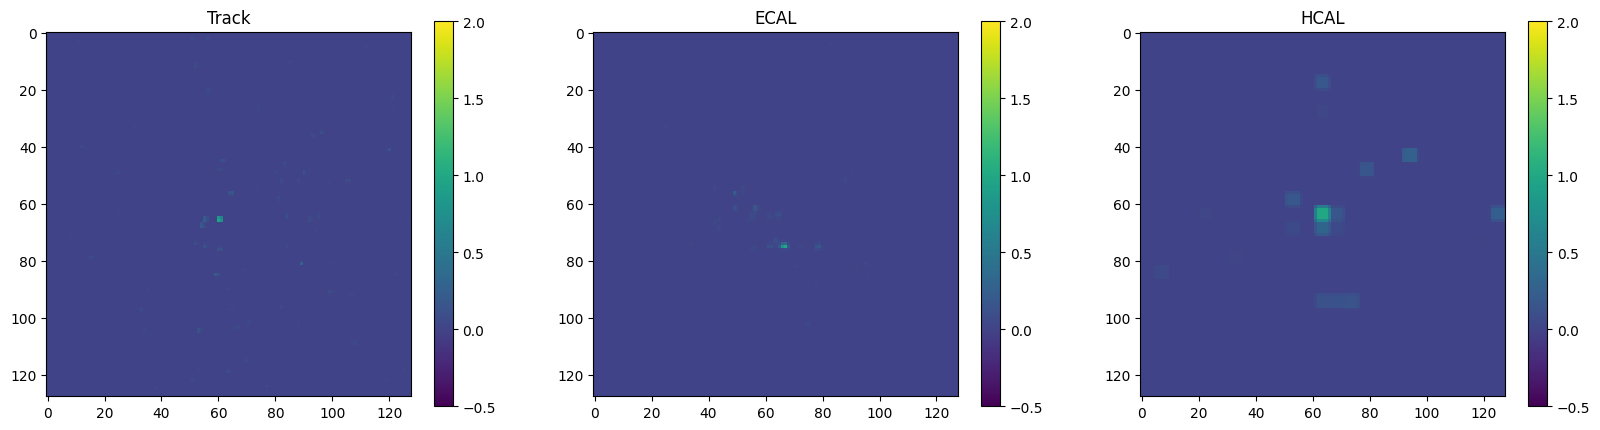

In [57]:
X_sample = X_jets[0]
#X_sample = (X_sample - np.min(X_sample)) / (np.max(X_sample) - np.min(X_sample))
# X_sample[:,:,0] = X_sample[:,:,0] * trackMax
# X_sample[:,:,1] = X_sample[:,:,1] * ecalMax
# X_sample[:,:,2] = X_sample[:,:,2] * hcalMax

print("For the first image among the batch passed : ")
print("Max value of intensity along 1st channel : ", np.max(X_sample[:,:,0]), "   Min value : ", np.min(X_sample[:,:,0]))
print("Max value of intensity along 2nd channel : ", np.max(X_sample[:,:,1]), "   Min value : ", np.min(X_sample[:,:,1]))
print("Max value of intensity along 3rd channel : ", np.max(X_sample[:,:,2]), "   Min value : ", np.min(X_sample[:,:,2]))
og_plot = plt.imshow(X_sample)


fig, axs = plt.subplots(1, 3, figsize=(20, 20))

im1 = axs[0].imshow(X_sample[:,:,0], cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
axs[0].set_title('Track')

im2 = axs[1].imshow(X_sample[:, :, 1], cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
axs[1].set_title('ECAL')

im3 = axs[2].imshow(X_sample[:, :,2], cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
axs[2].set_title('HCAL')

# Add colorbars
fig.colorbar(im1, ax=axs[0], shrink=0.25)
fig.colorbar(im2, ax=axs[1], shrink=0.25)
fig.colorbar(im3, ax=axs[2], shrink=0.25)


In [53]:
recon_img = reconstructed_image_scaled
# recon_img[:,:,0] = (recon_img[:,:,0] - np.min(recon_img[:,:,0]))/(np.max(recon_img[:,:,0]) - np.min(recon_img[:,:,0]))
# recon_img[:,:,1] = (recon_img[:,:,1] - np.min(recon_img[:,:,1]))/(np.max(recon_img[:,:,1]) - np.min(recon_img[:,:,1]))
# recon_img[:,:,2] = (recon_img[:,:,2] - np.min(recon_img[:,:,2]))/(np.max(recon_img[:,:,2]) - np.min(recon_img[:,:,2]))

### The reconstructed image is plotted as shown.

For the first image among the batch passed : 
Max value of intensity along 1st channel :  0.9994836    Min value :  0.0
Max value of intensity along 2nd channel :  0.996581    Min value :  0.0
Max value of intensity along 3rd channel :  0.99973154    Min value :  0.0


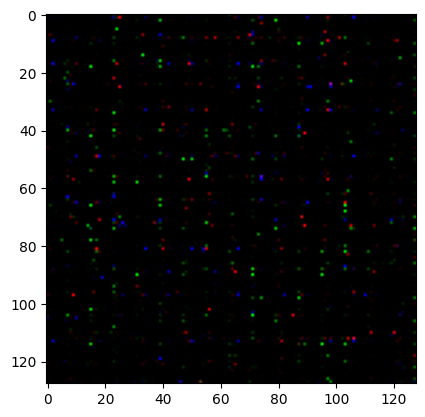

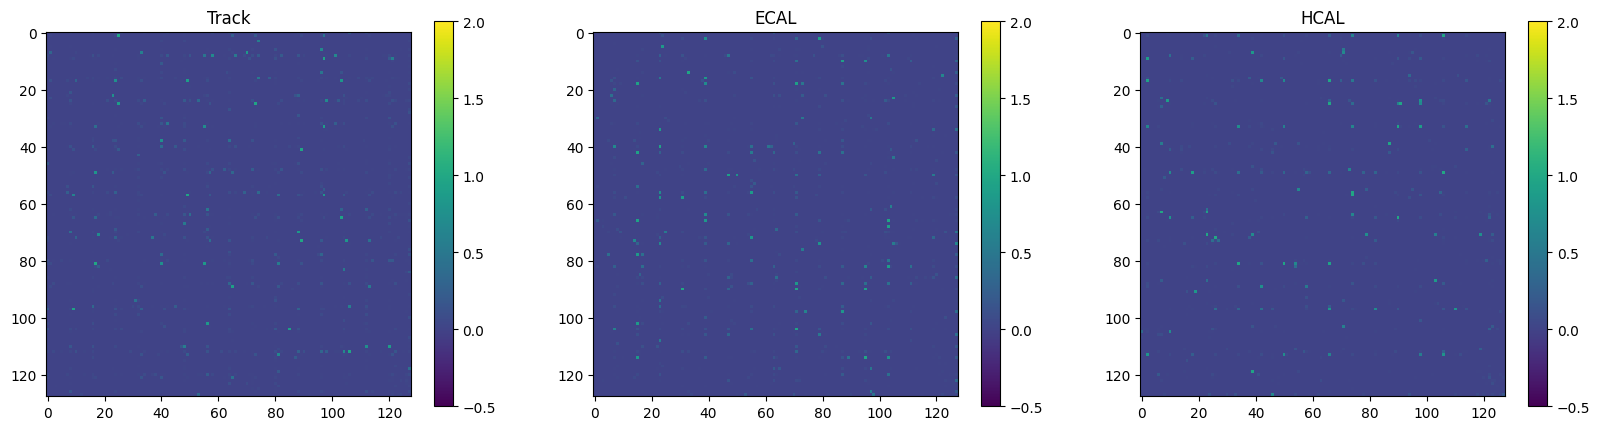

In [58]:
X_sample = recon_img
print("For the first image among the batch passed : ")
print("Max value of intensity along 1st channel : ", np.max(X_sample[:,:,0]), "   Min value : ", np.min(X_sample[:,:,0]))
print("Max value of intensity along 2nd channel : ", np.max(X_sample[:,:,1]), "   Min value : ", np.min(X_sample[:,:,1]))
print("Max value of intensity along 3rd channel : ", np.max(X_sample[:,:,2]), "   Min value : ", np.min(X_sample[:,:,2]))
# X_sample[:,:,0] = X_sample[:,:,0] * trackMax
# X_sample[:,:,1] = X_sample[:,:,1] * ecalMax
# X_sample[:,:,2] = X_sample[:,:,2] * hcalMax

og_plot = plt.imshow(X_sample)


fig, axs = plt.subplots(1, 3, figsize=(20, 20))

im1 = axs[0].imshow(X_sample[:,:,0], cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
axs[0].set_title('Track')

im2 = axs[1].imshow(X_sample[:, :, 1], cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
axs[1].set_title('ECAL')

im3 = axs[2].imshow(X_sample[:, :,2], cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
axs[2].set_title('HCAL')

# Add colorbars
fig.colorbar(im1, ax=axs[0], shrink=0.25)
fig.colorbar(im2, ax=axs[1], shrink=0.25)
fig.colorbar(im3, ax=axs[2], shrink=0.25)

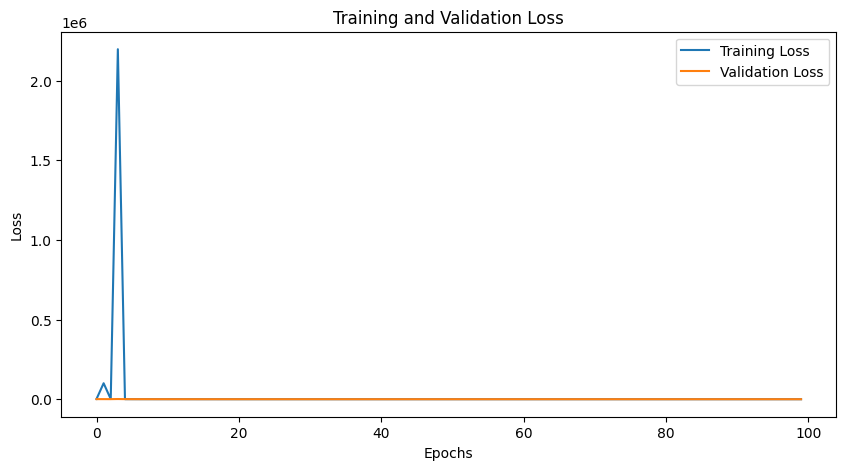

In [59]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()